In [25]:
import wget
import os
import statsmodels
import numpy as np
import pandas as pd 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot
from numpy import sqrt,mean,log,diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [26]:
from pmdarima import auto_arima

In [27]:
url = 'https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1459814400&period2=1617580800&interval=1d&events=history&includeAdjustedClose=true'
filename = 'GOOG.csv'
if os.path.exists(filename):
    print(filename)
    os.remove(filename) # if exist, remove it directly
    filename = wget.download(url) # download it to the specific path.
else: 
    filename = wget.download(url)
print(filename)

GOOG.csv


In [28]:
ggl = pd.read_csv("/Users/pravinraja/GOOG.csv")

In [29]:
ggl.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
1253,2021-03-26,2038.859985,2050.989990,2014.020020,2035.550049,2035.550049,1493500
1254,2021-03-29,2027.880005,2058.429932,2015.619995,2055.949951,2055.949951,1229800
1255,2021-03-30,2057.629883,2070.780029,2044.030029,2055.540039,2055.540039,1036600
1256,2021-03-31,2059.120117,2093.326904,2056.745117,2068.629883,2068.629883,1459900
1257,2021-04-01,2097.949951,2142.939941,2096.889893,2137.750000,2137.750000,1699000


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ggl.Date, y=ggl['Open'], name="Open",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=ggl.Date, y=ggl['High'], name="High",
                         line_color='dimgray'))

fig.add_trace(go.Scatter(x=ggl.Date, y=ggl['Low'], name="Low",
                         line_color='royalblue'))

fig.add_trace(go.Scatter(x=ggl.Date, y=ggl['Close'], name="Close",
                         line_color='firebrick'))

fig.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)
fig.show()

In [31]:
TimeSeries = pd.DataFrame(ggl, columns=["Date","Open","Volume"])

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=TimeSeries.Date,
                y=TimeSeries.Volume,
                name="Volume in Time-Stamp",
                line_color='deepskyblue',
                opacity=0.8))

fig.update_layout(xaxis_range=['2009-05-22','2018-08-29'],
                  title_text="Volume on Time-Stamp")
fig.show()

<ipython-input-33-e9759ae1de70>:7: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



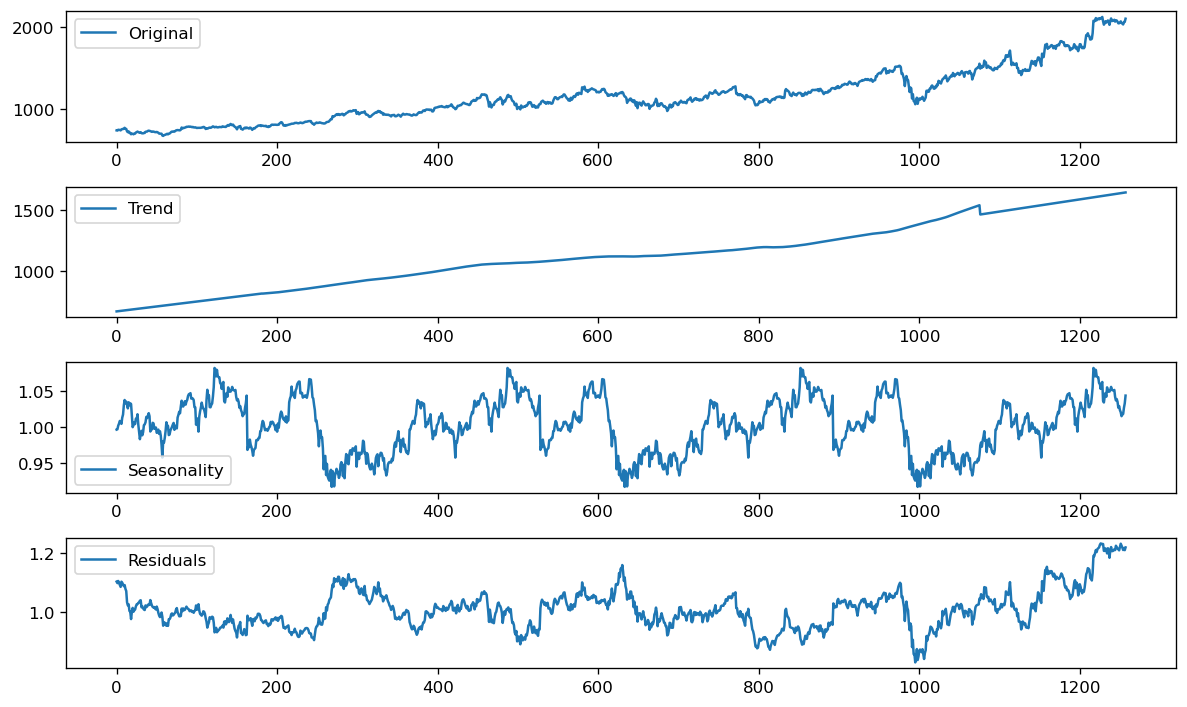

In [33]:
# result = seasonal_decompose(TimeSeries['Open'].values, model='multiplicative', extrapolate_trend='freq', freq=365)
# result.plot()
# plt.show();

plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})

decomposition = seasonal_decompose(TimeSeries['Open'].values, model='multiplicative', extrapolate_trend='freq', freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(TimeSeries['Open'].values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
Test = np.array(TimeSeries.Open)
result = adfuller(Test)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.583446
p-value: 0.987200


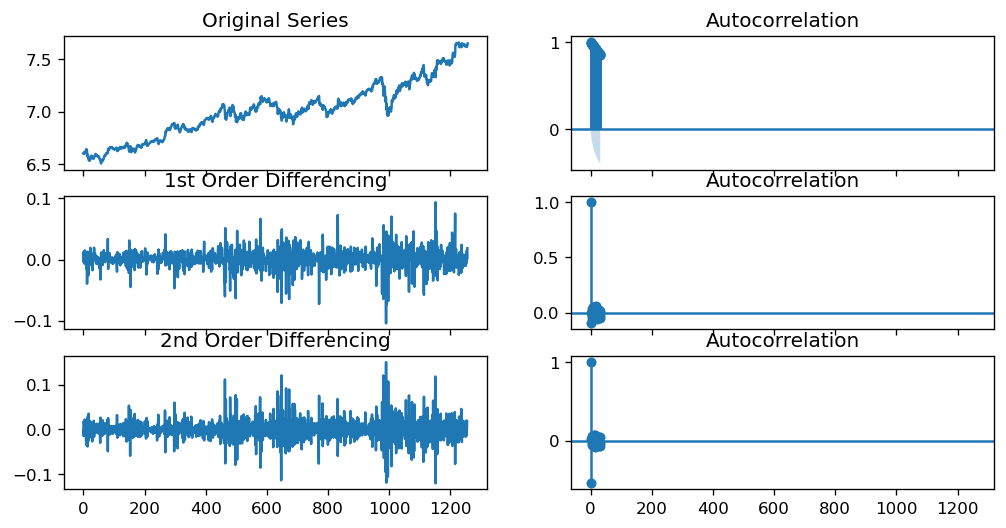

In [35]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
df = log(Test)
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(diff(df)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff(df), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(diff(diff(df))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf( diff(diff(df)), ax=axes[2, 1])

plt.show()

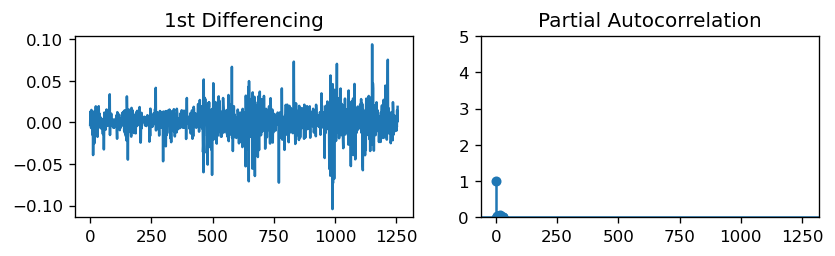

In [36]:
plt.rcParams.update({'figure.figsize':(8,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff(df)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff(df), ax=axes[1])

plt.show()

In [37]:
data = pd.DataFrame(ggl, columns=["Date","Open"])

In [38]:
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')
data.head()

,Open
Date,
2016-04-05,738.000000
2016-04-06,735.770020
2016-04-07,745.369995
2016-04-08,743.969971
2016-04-11,743.020020


In [39]:
train = data.loc['2009-05-22':'2016-12-01']
test = data.loc['2016-12-02':]

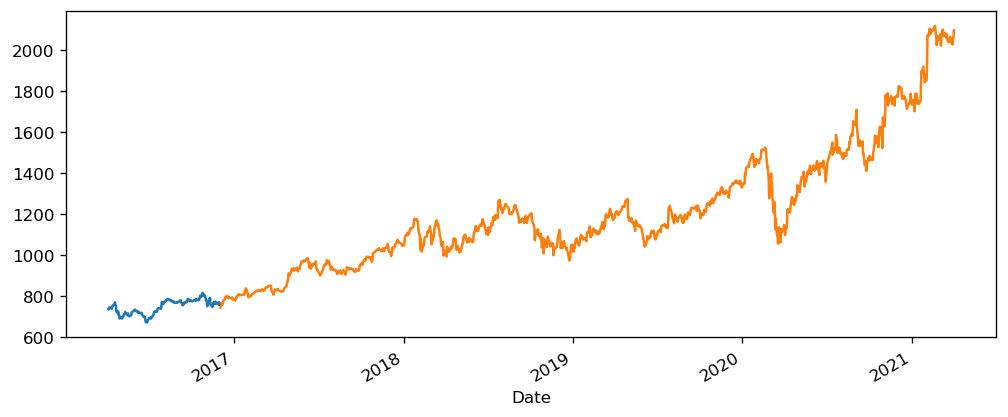

In [40]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
train['Open'].plot()
test['Open'].plot();

In [41]:
model = auto_arima(df, start_p=3, start_q=3,
                           max_p=5, max_q=5, m=25,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(1,1,1)[25]             : AIC=inf, Time=48.12 sec
 ARIMA(0,1,0)(0,1,0)[25]             : AIC=-5792.241, Time=0.97 sec
 ARIMA(1,1,0)(1,1,0)[25]             : AIC=-6110.000, Time=3.38 sec
 ARIMA(0,1,1)(0,1,1)[25]             : AIC=inf, Time=64.01 sec
 ARIMA(1,1,0)(0,1,0)[25]             : AIC=-5799.830, Time=1.31 sec
 ARIMA(1,1,0)(2,1,0)[25]             : AIC=-6232.221, Time=22.03 sec
 ARIMA(1,1,0)(2,1,1)[25]             : AIC=inf, Time=364.44 sec
 ARIMA(1,1,0)(1,1,1)[25]             : AIC=inf, Time=44.89 sec
 ARIMA(0,1,0)(2,1,0)[25]             : AIC=-6219.561, Time=15.76 sec
 ARIMA(2,1,0)(2,1,0)[25]             : AIC=-6230.237, Time=33.46 sec
 ARIMA(1,1,1)(2,1,0)[25]             : AIC=-6230.137, Time=18.26 sec
 ARIMA(0,1,1)(2,1,0)[25]             : AIC=-6232.021, Time=17.87 sec
 ARIMA(2,1,1)(2,1,0)[25]             : AIC=-6228.225, Time=30.73 sec
 ARIMA(1,1,0)(2,1,0)[25] intercept   : AIC=-6230.260, Time=87.92 sec

Best model:  ARI

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 25),
      suppress_warnings=True, with_intercept=False)

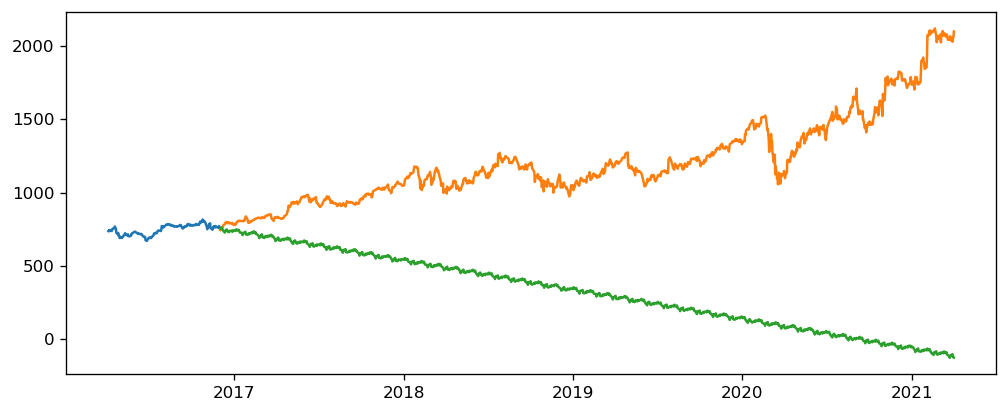

In [44]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Open_test'])

plt.plot(train, label='Train')
plt.plot(test, label='Valid')
plt.plot(forecast, label='Prediction')
strFile = "/usr/local/var/www/Google.png"
if os.path.isfile(strFile):
   os.remove(strFile)   # Opt.: os.system("rm "+strFile)
plt.savefig(strFile)

#plt.savefig('PFE.png')

#html = 'Pfizer Arima Model' + '<img src=\'PFE.png\'>' 

#with open('PFE.html','w') as f:
 #   f.write(html) 
#plt.show()
